<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis 
* iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta

import os 
import re 

from functools import reduce 
from collections import defaultdict, ChainMap, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'online_retail_II.xlsx',
 'sample_data']

In [15]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [16]:
df.columns = ['_'.join(re.split(r'(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower().replace(' ', '_') for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [17]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]

In [18]:
df.invoice_date = pd.to_datetime(df.invoice_date)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.unit_price * df.quantity
df = df[['customerid', 'date', 'month', 'rev']].rename(columns = {'customerid':'id'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,12346.0,2011-01-18,2011-01-01,77183.60
1,12747.0,2010-12-05,2010-12-01,358.56
2,12747.0,2010-12-13,2010-12-01,347.71
3,12747.0,2011-01-20,2011-01-01,303.04
4,12747.0,2011-03-01,2011-03-01,310.78


In [19]:
df_ = df.assign(week = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]'))
df_.head()

,id,date,month,rev,week
0,12346.0,2011-01-18,2011-01-01,77183.60,2011-01-17
1,12747.0,2010-12-05,2010-12-01,358.56,2010-11-29
2,12747.0,2010-12-13,2010-12-01,347.71,2010-12-13
3,12747.0,2011-01-20,2011-01-01,303.04,2011-01-17
4,12747.0,2011-03-01,2011-03-01,310.78,2011-02-28


In [20]:
list_npu = df_.groupby(['id']).agg({'date': lambda x : x.min()}).reset_index().rename(columns = {'date':'npu_date'})
list_npu.head()

,id,npu_date
0,12346.0,2011-01-18
1,12747.0,2010-12-05
2,12748.0,2010-12-01
3,12749.0,2011-05-10
4,12820.0,2011-01-17


In [21]:
df_ = pd.merge(df_, list_npu, 'left', 'id')
df_.head()

,id,date,month,rev,week,npu_date
0,12346.0,2011-01-18,2011-01-01,77183.60,2011-01-17,2011-01-18
1,12747.0,2010-12-05,2010-12-01,358.56,2010-11-29,2010-12-05
2,12747.0,2010-12-13,2010-12-01,347.71,2010-12-13,2010-12-05
3,12747.0,2011-01-20,2011-01-01,303.04,2011-01-17,2010-12-05
4,12747.0,2011-03-01,2011-03-01,310.78,2011-02-28,2010-12-05


In [22]:
df_['days'] = (df_['date'] - df_['npu_date']).dt.days
df_.head()

,id,date,month,rev,week,npu_date,days
0,12346.0,2011-01-18,2011-01-01,77183.60,2011-01-17,2011-01-18,0
1,12747.0,2010-12-05,2010-12-01,358.56,2010-11-29,2010-12-05,0
2,12747.0,2010-12-13,2010-12-01,347.71,2010-12-13,2010-12-05,8
3,12747.0,2011-01-20,2011-01-01,303.04,2011-01-17,2010-12-05,46
4,12747.0,2011-03-01,2011-03-01,310.78,2011-02-28,2010-12-05,86


In [26]:
cnt_pu = df_.groupby(['week', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt_pu['ratio'] = round(cnt_pu['pu']/cnt_pu['pu'].max() * 100, 2)
cnt_pu['week'] = cnt_pu['week'].astype(str)
cnt_pu.head()

,week,days,pu,ratio
0,2010-11-29,0,278,86.88
1,2010-11-29,1,5,1.56
2,2010-11-29,2,4,1.25
3,2010-11-29,4,5,1.56
4,2010-12-06,0,320,100.00


In [27]:
cnt_pu = pd.melt(cnt_pu, id_vars = ['week','days'], var_name = 'type')
cnt_pu.head()

,week,days,type,value
0,2010-11-29,0,pu,278.0
1,2010-11-29,1,pu,5.0
2,2010-11-29,2,pu,4.0
3,2010-11-29,4,pu,5.0
4,2010-12-06,0,pu,320.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


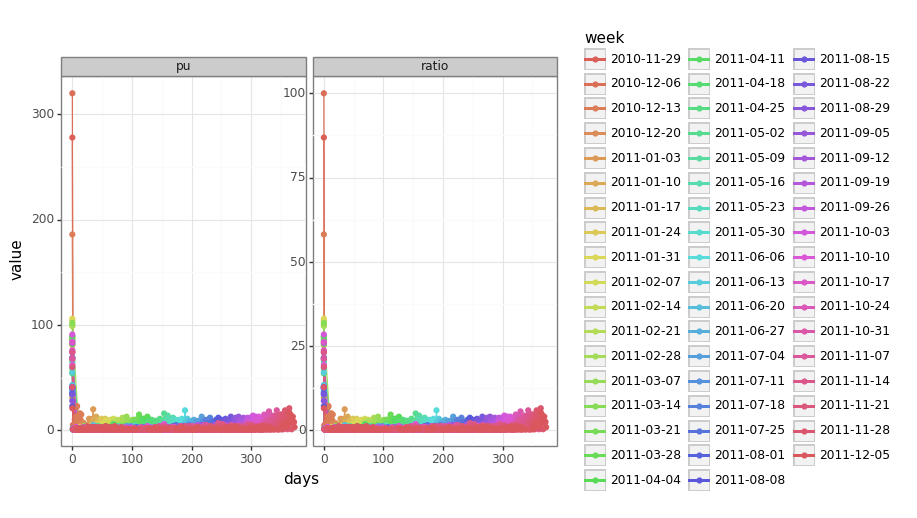

<ggplot: (8786227705169)>

In [28]:
(
    ggplot(cnt_pu, aes('days', 'value', color = 'week')) + 
    gg.geom_line() +
    gg.geom_point() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [29]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[f'({r}, {c})-{letters}' for r, rows in enumerate(mat) for c, letters in enumerate(rows)]


['(0, 0)-A',
 '(0, 1)-B',
 '(0, 2)-C',
 '(1, 0)-D',
 '(1, 1)-E',
 '(1, 2)-F',
 '(2, 0)-G',
 '(2, 1)-H',
 '(2, 2)-I']

In [30]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [32]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]],users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}